In [1]:
import re

import numpy as np
import pandas as pd

In [2]:
from tqdm.autonotebook import tqdm

/var/folders/kz/mqbx964j4w53vxgzd7rlzx380000gn/T/ipykernel_17983/987820437.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Importing Datasets

In [3]:
string_df = pd.read_csv("../../data/interim/string_df.csv", index_col=0)

balanced_pairs_df = pd.read_csv("../../data/train_test/train_pairs.csv", index_col=0)

balanced_pairs_df.drop_duplicates(inplace=True)
balanced_pairs_df.reset_index(drop=True, inplace=True)

In [4]:
string_df

,concatenated
label,
GooglePixel3A_L,0000000000000000000000000000000000000000000000...
GooglePixel3A_L,0000000000000000000000000000000000000000000000...
GooglePixel3A_L,0000000000000000000000000000000000000000000000...
GooglePixel3A_L,0000000000000000000000000000000000000000000000...
GooglePixel3A_L,0000000000000000000000000000000000000000000000...
...,...
iPhoneXSMax_M,0001101000101101000000000001101111111111000000...
iPhoneXSMax_M,0001101000101101010000000001101111111111000000...
iPhoneXSMax_M,0001101000101101000000000001101111111111000000...


In [5]:
balanced_pairs_df

,Item 1,Item 2,Equality,device1,device2
0,370,383,1,XiaomiRedmi5_J,XiaomiRedmi5_J
1,238,242,1,XiaomiRedmiNote7_S,XiaomiRedmiNote7_S
2,225,268,1,XiaomiRedmiNote7_S,XiaomiRedmiNote7_S
3,408,462,1,XiaomiRedmiNote9S_T,XiaomiRedmiNote9S_T
4,716,718,1,iPhone7_F,iPhone7_F
...,...,...,...,...,...
1995,31,241,-1,XiaomiRedmi4_B,XiaomiRedmiNote7_S
1996,245,489,-1,XiaomiRedmiNote7_S,OnePlusNord_O
1997,335,543,-1,XiaomiRedmi5_J,XiaomiA2_E
1998,150,329,-1,HuaweiHonor9_R,XiaomiRedmi5_J


## Importing Best Configurations

In [6]:
import re
import pandas as pd


def parse_log_file(filename):
    data = []

    with open(filename, "r") as file:
        lines = file.readlines()

        current_filter = None
        current_threshold = None
        current_min_error = None
        current_confidence = None

        for line in lines:
            if "Best Filter" in line:
                # Extract Best Filter using regex
                filter_match = re.search(r"Best Filter: (.+)", line)
                if filter_match:
                    current_filter = filter_match.group(1).strip()

            elif "Best Threshold" in line:
                # Extract Best Threshold using regex
                threshold_match = re.search(r"Best Threshold: (.+)", line)
                if threshold_match:
                    current_threshold = int(threshold_match.group(1).strip())

            elif "Min error" in line:
                # Extract Min Error using regex
                min_error_match = re.search(r"Min error: (.+)", line)
                if min_error_match:
                    current_min_error = float(min_error_match.group(1).strip())

            elif "Confidence" in line:
                # Extract Confidence using regex
                confidence_match = re.search(r"Confidence: (.+)", line)
                if confidence_match:
                    current_confidence = float(confidence_match.group(1).strip())

                    # Once we have all values, create a tuple and add it to the data list
                    data.append(
                        (
                            current_filter,
                            current_threshold,
                            current_min_error,
                            current_confidence,
                        )
                    )

                    # Reset current values for the next entry
                    current_filter = None
                    current_threshold = None
                    current_min_error = None
                    current_confidence = None

    # Convert the list of tuples into a DataFrame
    df = pd.DataFrame(
        data, columns=["Best Filter", "Best Threshold", "Min Error", "Confidence"]
    )

    return df

In [7]:
# Usage example:
filename = "../../reports/best_config"
best_configs_df = parse_log_file(filename)

In [8]:
best_configs_df

,Best Filter,Best Threshold,Min Error,Confidence
0,0[304] 🀆🀆🀆🀆🀆🀆🀆🀆🀫🀫🀫🀫🀫🀫🀫🀫 0[1464],1,0.453672,0.185844
1,0[1752] 🀆🀆🀆🀆🀫🀫🀫🀫 0[24],1,0.459875,0.160845
2,0[328] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1448],1,0.460774,0.157226
3,0[304] 🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫 0[1464],2,0.461820,0.153019
4,0[1664] 🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫🀫 0[104],1,0.459515,0.162296
5,0[8] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1768],1,0.315618,0.773985
6,0[8] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1768],3,0.349022,0.623341
7,0[24] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1752],1,0.291000,0.890532
8,0[8] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1768],1,0.315618,0.773985
9,0[8] 🀫🀫🀫🀫🀫🀫🀫🀫 0[1768],3,0.349022,0.623341


In [9]:
# best_configs_df = best_configs_df.head(5)

In [10]:
compression_rate = len(string_df["concatenated"][0]) / best_configs_df.shape[0]

print("Compression Rate:", compression_rate)

Compression Rate: 148.66666666666666


/var/folders/kz/mqbx964j4w53vxgzd7rlzx380000gn/T/ipykernel_17983/3562695690.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  compression_rate = len(string_df["concatenated"][0]) / best_configs_df.shape[0]


## Generate Matrix

In [11]:
def convertColumntoArray(df: pd.DataFrame, column_name: str) -> np.array:
    return np.array([list(bstr) for bstr in df[column_name]])

In [12]:
def generateStringPairDf(pairs_df: pd.DataFrame, dataset: pd.DataFrame) -> pd.DataFrame:
    # Convert the Probes column to a numpy array
    dataset_array = convertColumntoArray(dataset, "concatenated")

    return_df = pd.DataFrame()

    # Import the Probes into the pairs_df dataframe
    return_df["Item 1"] = pairs_df["Item 1"].apply(lambda index: dataset_array[index])
    return_df["Item 2"] = pairs_df["Item 2"].apply(lambda index: dataset_array[index])
    return_df["Equality"] = pairs_df["Equality"]

    return return_df

In [13]:
matrix_pairs_df = generateStringPairDf(balanced_pairs_df, string_df)
matrix_pairs_df.reset_index(inplace=True, drop=True)

## Filters Parser

In [14]:
def filter_parser(input_string: str) -> list:
    # Split the string into its parts
    parts = input_string.split()

    # Initialize the final array
    result = []

    # Process each part
    for part in parts:
        if part.startswith("0["):
            # Extract the number inside the brackets
            count = int(part[2:-1])
            # Append the corresponding number of zeros to the result
            result.extend([0] * count)
        else:
            # Translate the tiles to their respective values
            for char in part:
                if char == "🀆":
                    result.append(-1)
                elif char == "🀫":
                    result.append(1)

    return result

In [15]:
# import time

# time.sleep(100)

## Apply Filters

In [16]:
def apply_filter(item, filter):
    # item = np.array(list(item)).astype(int)
    item = item.astype(int)
    filter = filter_parser(filter)
    return np.sum(np.multiply(item, filter))

In [17]:
def apply_filter_threshold(item, filter, threshold) -> int:
    if apply_filter(item, filter) > threshold:
        return 1
    else:
        return -1

In [18]:
def apply_filter_threshold_pair(item_1, item_2, filter, threshold) -> int:
    if apply_filter_threshold(item_1, filter, threshold) == apply_filter_threshold(
        item_2, filter, threshold
    ):
        return 1
    else:
        return -1

## Calculate Fingerprint

In [19]:
def hamming_distance(array1, array2, confidence):
    # Check if arrays have the same length
    if len(array1) != len(array2):
        raise ValueError("Arrays must have the same length")

    # Initialize distance counter
    distance = 0

    # Iterate through arrays and count differences
    for i in range(len(array1)):
        if array1[i] != array2[i]:
            distance += confidence[i]

    distance = (distance / sum(confidence)) * len(confidence)

    return distance

In [20]:
def calculate_fingerprint(item_1, item_2, best_filters, best_thresholds, confidence):
    fingerprint_1 = []
    fingerprint_2 = []

    for best_filter, best_threshold in zip(best_filters, best_thresholds):
        filtered_1 = np.sum(np.multiply(item_1.astype(int), filter_parser(best_filter)))
        filtered_2 = np.sum(np.multiply(item_2.astype(int), filter_parser(best_filter)))

        if filtered_1 > best_threshold:
            filtered_1 = 1
        else:
            filtered_1 = -1

        if filtered_2 > best_threshold:
            filtered_2 = 1
        else:
            filtered_2 = -1

        fingerprint_1.append(filtered_1)
        fingerprint_2.append(filtered_2)

        distance = hamming_distance(fingerprint_1, fingerprint_2, confidence)

    return distance

In [21]:
for i, row in tqdm(matrix_pairs_df.iterrows(), total=matrix_pairs_df.shape[0]):
    # Extracting best filters and thresholds from the main DataFrame (assuming same filters and thresholds for simplicity)
    best_filters = best_configs_df["Best Filter"].tolist()
    best_thresholds = best_configs_df["Best Threshold"].tolist()
    confidence = best_configs_df["Confidence"].tolist()

    # Calculate the fingerprint using the relevant best filters and thresholds
    fingerprint = calculate_fingerprint(
        row["Item 1"], row["Item 2"], best_filters, best_thresholds, confidence
    )

    # Store the result in the 'distance' column (or any other processing you need)
    matrix_pairs_df.at[i, "h_distance"] = fingerprint

  0%|          | 0/2000 [00:00<?, ?it/s]

## Thresholding w/ $\tau$

In [22]:
taus = range(1, len(best_configs_df) + 1, 1)

In [23]:
for tau in taus:
    matrix_pairs_df[f"tau_{tau}"] = np.where(matrix_pairs_df["h_distance"] < tau, 1, -1)

In [24]:
matrix_pairs_df

,Item 1,Item 2,Equality,h_distance,tau_1,tau_2,tau_3,tau_4,tau_5,tau_6,tau_7,tau_8,tau_9,tau_10,tau_11,tau_12
0,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, ...",1,0.000000,1,1,1,1,1,1,1,1,1,1,1,1
1,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, ...",1,0.000000,1,1,1,1,1,1,1,1,1,1,1,1
2,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, ...",1,3.962162,-1,-1,-1,1,1,1,1,1,1,1,1,1
3,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, ...",1,0.372627,1,1,1,1,1,1,1,1,1,1,1,1
4,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, ...",1,0.000000,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, ...",-1,7.242935,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1
1996,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, ...",-1,6.025251,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1
1997,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, ...",-1,6.379750,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1
1998,"[0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, ...",-1,2.417588,-1,-1,1,1,1,1,1,1,1,1,1,1


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [27]:
# Total number of cases
total_cases = len(matrix_pairs_df)

# Find all columns that contain 'tau_' in their name
tau_columns = [col for col in matrix_pairs_df.columns if "tau_" in col]

# Initialize lists to store metrics
tau_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Iterate over each tau column
for tau in tau_columns:
    # True Positives (TP)
    TP = ((matrix_pairs_df["Equality"] == 1) & (matrix_pairs_df[tau] > 0)).sum()
    # True Negatives (TN)
    TN = ((matrix_pairs_df["Equality"] == -1) & (matrix_pairs_df[tau] <= 0)).sum()
    # False Positives (FP)
    FP = ((matrix_pairs_df["Equality"] == -1) & (matrix_pairs_df[tau] > 0)).sum()
    # False Negatives (FN)
    FN = ((matrix_pairs_df["Equality"] == 1) & (matrix_pairs_df[tau] <= 0)).sum()

    # Calculate metrics
    accuracy = (TP + TN) / total_cases

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0.0

    if TP + FN > 0:
        recall = TP / (TP + FN)
    else:
        recall = 0.0

    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0

    # Append metrics to lists
    tau_list.append(tau)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Create metrics DataFrame
metrics_df = pd.DataFrame(
    {
        "Tau": tau_list,
        "Accuracy": accuracy_list,
        "Precision": precision_list,
        "Recall": recall_list,
        "F1": f1_list,
    }
)

In [29]:
metrics_df

,Tau,Accuracy,Precision,Recall,F1
0,tau_1,0.8435,0.850868,0.833,0.841839
1,tau_2,0.8485,0.838678,0.863,0.850665
2,tau_3,0.8090,0.777379,0.866,0.819300
3,tau_4,0.7135,0.653047,0.911,0.760752
4,tau_5,0.7035,0.637222,0.945,0.761176
5,tau_6,0.6505,0.592615,0.963,0.733714
6,tau_7,0.5620,0.533405,0.990,0.693277
7,tau_8,0.5445,0.523286,1.000,0.687049
8,tau_9,0.5180,0.509165,1.000,0.674764
9,tau_10,0.5075,0.503778,1.000,0.670017


## ROC

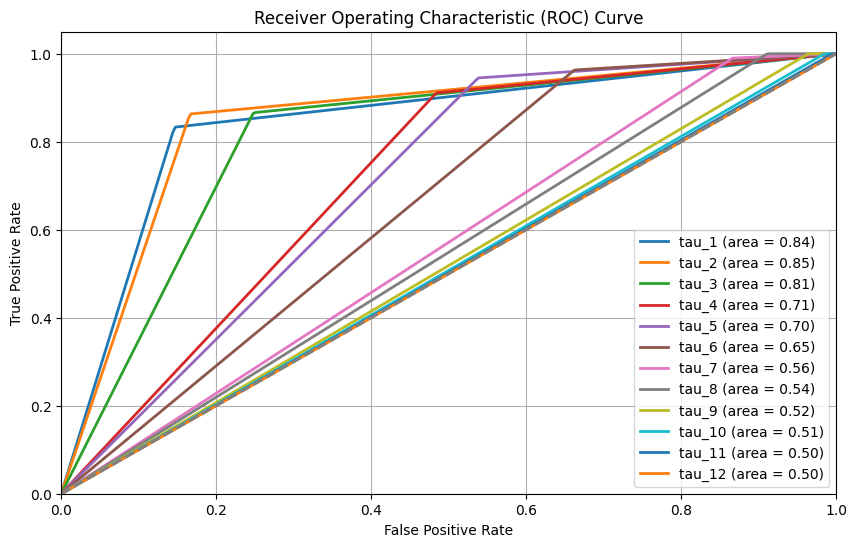

In [30]:
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Assuming matrix_pairs_df is your DataFrame
# True labels
y_true = matrix_pairs_df["Equality"]

plt.figure(figsize=(10, 6))

# Loop through each prediction column
for column in matrix_pairs_df.columns:
    if column.startswith("tau_"):
        # Predicted scores
        y_scores = matrix_pairs_df[column]

        # Compute ROC curve and ROC area
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = roc_auc_score(y_true, y_scores)

        # Smooth the ROC curve using linear interpolation
        x_new = np.linspace(
            fpr.min(), fpr.max(), 300
        )  # Increase the number of points for smooth curve
        f = interp1d(fpr, tpr, kind="linear")  # Linear interpolation
        tpr_smooth = f(x_new)

        # Plot ROC curve
        plt.plot(x_new, tpr_smooth, lw=2, label=f"{column} (area = %0.2f)" % roc_auc)

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--")

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)  # Add grid
plt.show()

In [31]:
smoothness = 7

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

# Assuming matrix_pairs_df is your DataFrame
# True labels
y_true = matrix_pairs_df["Equality"]

# Initialize lists to collect TPR values for each column
tpr_list = []
fpr_list = []
auc_list = []

# Loop through each prediction column
for column in matrix_pairs_df.columns:
    if column.startswith("tau_"):
        # Predicted scores
        y_scores = matrix_pairs_df[column]

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_scores)

        # Compute AUC
        roc_auc = auc(fpr, tpr)
        auc_list.append((roc_auc, fpr, tpr, column))

        # Interpolate to get smooth ROC curve
        x_new = np.linspace(fpr.min(), fpr.max(), 300)
        f = interp1d(fpr, tpr, kind="linear")
        tpr_smooth = f(x_new)

        # Store the smooth TPR and corresponding FPR
        tpr_list.append(tpr_smooth)
        fpr_list.append(x_new)

# Find the tau column with the maximum AUC and the minimum AUC
max_auc, max_fpr, max_tpr, max_column = max(auc_list, key=lambda x: x[0])
min_auc, min_fpr, min_tpr, min_column = min(auc_list, key=lambda x: x[0])

# Interpolate the max and min TPR for smoothness
x_new_max = np.linspace(max_fpr.min(), max_fpr.max(), 300)
f_max = interp1d(max_fpr, max_tpr, kind="linear")
max_tpr_smooth = f_max(x_new_max)

x_new_min = np.linspace(min_fpr.min(), min_fpr.max(), 300)
f_min = interp1d(min_fpr, min_tpr, kind="linear")
min_tpr_smooth = f_min(x_new_min)

# Calculate the average TPR across all columns
avg_tpr = np.mean(tpr_list, axis=0)

# Calculate the AUC for the average ROC curve
avg_auc = auc(fpr_list[0], avg_tpr)

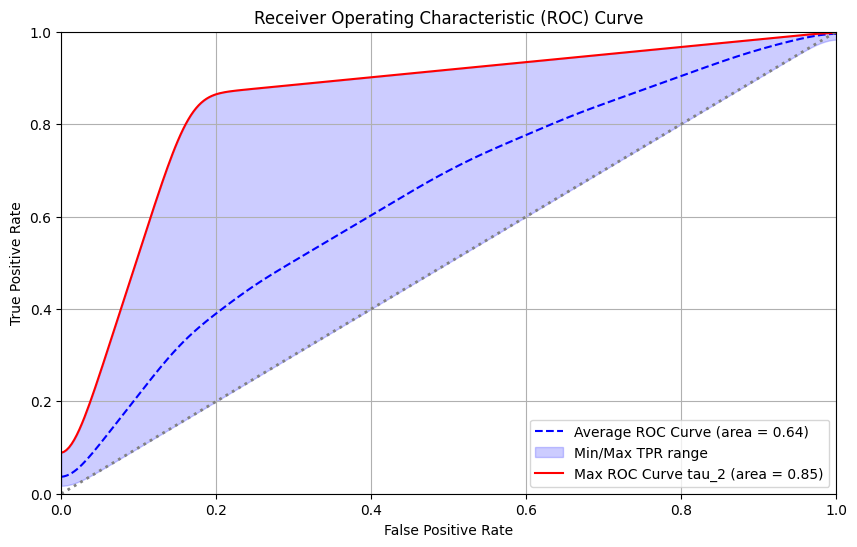

In [33]:
from scipy.ndimage import gaussian_filter1d

# Smooth the average TPR curve by averaging across columns
smooth_avg_tpr = np.mean(tpr_list, axis=0)

# Apply Gaussian filter to smooth the average TPR curve
smooth_avg_tpr_smooth = gaussian_filter1d(smooth_avg_tpr, sigma=smoothness)

# Apply Gaussian filter to smooth the min and max TPR curves
min_tpr_smooth_smooth = gaussian_filter1d(min_tpr_smooth, sigma=smoothness)
max_tpr_smooth_smooth = gaussian_filter1d(max_tpr_smooth, sigma=smoothness)

# Plot the average ROC curve with seaborn
plt.figure(figsize=(10, 6))

sns.lineplot(
    x=fpr_list[0],
    y=smooth_avg_tpr_smooth,
    label=f"Average ROC Curve (area = {avg_auc:.2f})",
    color="blue",
    linestyle="--",
)

# Plot the filled area between min and max TPR
plt.fill_between(
    x_new_max,
    min_tpr_smooth_smooth,
    max_tpr_smooth_smooth,
    color="blue",
    alpha=0.2,
    label="Min/Max TPR range",
)

# Plot the maximum ROC curve
sns.lineplot(
    x=x_new_max,
    y=max_tpr_smooth_smooth,
    label=f"Max ROC Curve {max_column} (area = {max_auc:.2f})",
    color="red",
)

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="dotted")

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()